In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression as LogRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score, auc, roc_curve, average_precision_score
from copy import deepcopy
from IPython.display import clear_output

In [2]:
dict_replace = {"?": np.nan}
data_heart = pd.read_csv("processed.cleveland.data.txt", header = None)
data_heart = data_heart.replace(dict_replace).dropna()
y_heart = (data_heart.loc[:, 13] > 0).values.astype(int)
X_heart = (data_heart.loc[:,:12]).values
X_train_heart, X_test_heart, y_train_heart, y_test_heart = train_test_split(X_heart, y_heart,
                                                                            test_size = 0.5, random_state=42)

## 20 a)

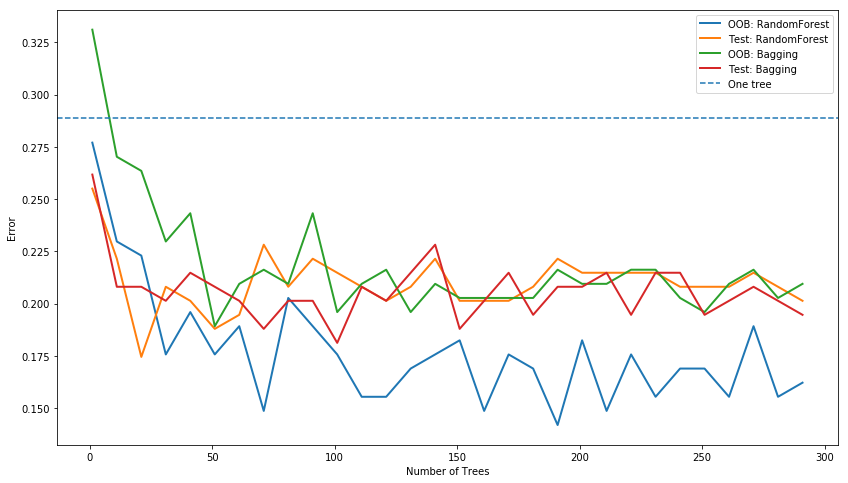

In [3]:
def classification_error(y_pred, y_true):
    return np.sum(y_pred != y_true)/np.size(y_pred)

dec_tree = DecisionTreeClassifier()
dec_tree.fit(X_train_heart, y_train_heart)
score_one_tree = classification_error(dec_tree.predict(X_test_heart), y_test_heart)


def tree_oob_test_scores(X_train, X_test, y_train, y_test, max_estimators = 300, steps = 1,
                         classifiers = ["RandomForests", "Bagging"], m_features = None):
    iter_tree_sizes = range(1, max_estimators + 1, steps) ## Begin using 18 classifiers to avoid not
                                                ## having enough trees to compute the OOB error
    oob_scores = {key: np.zeros(len(iter_tree_sizes)) for key in classifiers}
    test_scores = deepcopy(oob_scores)
    
    for idx, nTrees in enumerate(iter_tree_sizes):

        for classifier in classifiers:
            if classifier == "RandomForest":
                if m_features == None:
                    p_features = np.shape(X_test)[1]
                    m_use_features = int(np.sqrt(p_features))
                else:
                    m_use_features = m_features
                clf = RandomForestClassifier(n_estimators = nTrees, oob_score = True, max_features = m_use_features)
            else:
                clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators = nTrees, oob_score = True)
                
            clf.fit(X_train, y_train)
            oob_scores[classifier][idx] = 1 - clf.oob_score_
            test_scores[classifier][idx] = classification_error(clf.predict(X_test), y_test)
            clear_output()
            
    return oob_scores, test_scores, iter_tree_sizes

def plot_tree_clf_oob_test_scores(X_train, X_test, y_train, y_test, max_estimators = 300,
                                  steps = 1, classifiers = ["RandomForest", "Bagging"], baseline = None):
    args = locals()
    del args["baseline"]
    oob_scores, test_scores, iter_tree_sizes = tree_oob_test_scores(**args)
    fig = plt.figure(figsize = (14, 8))
    for key in oob_scores:
        plt.plot(iter_tree_sizes, oob_scores[key], label = f"OOB: {key}", lw = 2)
        plt.plot(iter_tree_sizes, test_scores[key], label = f"Test: {key}", lw = 2)
    if baseline != None:
        plt.axhline(baseline, ls = "--",label = "One tree")
    plt.xlabel("Number of Trees")
    plt.ylabel("Error")
    plt.legend(loc = "best")
        
    
max_estimators = 300
plot_tree_clf_oob_test_scores(X_train_heart, X_test_heart, y_train_heart, y_test_heart, max_estimators,
                              steps = 10, classifiers = ["RandomForest", "Bagging"], baseline = score_one_tree)

## 20 b)

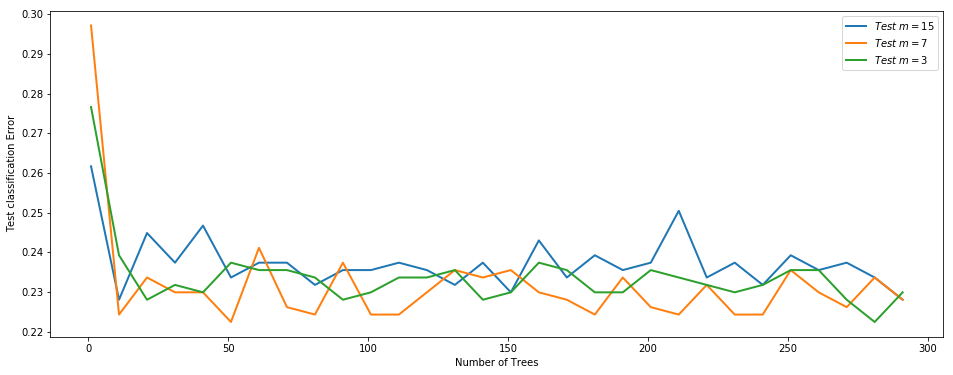

In [4]:
data_juice = pd.read_csv("OJ.csv")
y_juice = (data_juice["Purchase"] == "CH").values.astype(int)
feature_keys = list(set(data_juice.columns) - {'Unnamed: 0', 'Store7', 'Purchase', 'STORE'})
X_juice = data_juice[feature_keys].values
X_train_juice, X_test_juice, y_train_juice, y_test_juice = train_test_split(X_juice, y_juice,
                                                                            test_size = 0.5, random_state=42)

p = np.shape(X_juice)[1] ##Total number of possible features
m_features = list(map(int, [p, p/2, np.sqrt(p)]))
max_estimators = 300
def plot_random_forest_test_scores_m(X_train, X_test, y_train, y_test, max_estimators,
                                          steps = 5, m_features = None, plot_oob = False):
    args = locals()
    args["classifiers"] = ["RandomForest"]
    del args["plot_oob"]
    if m_features == None:
        p = np.shape(X_juice)[1]
        m_features_iter = [np.sqrt(p)]
    else:
        m_features_iter = m_features
        
    fig = plt.figure(figsize = (16, 6))
    for m in m_features_iter:
        args["m_features"] = m
        oob_scores, test_scores, iter_tree_sizes = tree_oob_test_scores(**args)
        if plot_oob:
            plt.plot(iter_tree_sizes, oob_scores["RandomForest"], label = f"$OOB\ m = {m}$", lw = 2)
        plt.plot(iter_tree_sizes, test_scores["RandomForest"], label = fr"$Test\ m = {m}$", lw = 2)
    plt.ylabel("Test classification Error")
    plt.xlabel("Number of Trees")
    plt.legend(loc = "best")
plot_random_forest_test_scores_m(X_train_juice, X_test_juice, y_train_juice, y_test_juice, max_estimators,
                              steps = 10, m_features = m_features ) 

## 20 c)

In [5]:
def cross_validate_simple_clf(clf_instance, x_train, x_test, y_train, y_test, kfold_n_splits = 6, score = None):
    if score == "ROC":
        scoring  = "roc_auc"
        error_score = roc_curve
    elif score == "PrecisionRecall":
        scoring = "average_precision"
        error_score = average_precision_score
    elif score == None or score == "Error":
        scoring = "accuracy"
        error_score = lambda y_true,y_pred: 1 - accuracy_score(y_true,y_pred)
    
    cv_score = cross_validate(clf_instance, x_train, y_train, cv = kfold_n_splits, scoring = scoring, 
                                    return_train_score = True, return_estimator = True)
    fitted_estim_cv = cv_score["estimator"]
    
    score_keys = ["train_score", "std_train", "validate_score", "std_validate", "test_score", "std_test"]        
    dict_cv = {key: 0 for key in score_keys}
    dict_cv["train_score"] = cv_score["train_score"].mean()
    dict_cv["std_train"] = cv_score["train_score"].std()
    dict_cv["validate_score"] = cv_score["test_score"].mean()
    dict_cv["std_validate"] = cv_score["test_score"].std()
    
    if score == None or score == "Error":
        test_scores = np.array([error_score(fitted_estim.predict(x_test), y_test) 
                                for fitted_estim in fitted_estim_cv])
    elif score == "ROC":
        y_pred_probs = [fitted_estim.predict_proba(x_test)[:, 1] for fitted_estim in fitted_estim_cv]
        fpr_tpr = [error_score(y_test, pred_probs) for pred_probs in y_pred_probs]
        test_scores = np.array([auc(fpr, tpr) for [fpr, tpr, _] in fpr_tpr])

    elif score == "PrecisionRecall":
        y_pred_probs = [fitted_estim.predict_proba(x_test)[:, 1] for fitted_estim in fitted_estim_cv]
        test_scores = np.array([error_score(y_test, pred_probs) for pred_probs in y_pred_probs])
        
    dict_cv["test_score"] = test_scores.mean()
    dict_cv["std_test"] = test_scores.std()
    
    for key_score in ["train_score", "validate_score"]:
        if score == None or score == "Error":                
            dict_cv[key_score] = 1 - dict_cv[key_score]
    clear_output()       
    return dict_cv

def cross_validate_scores(clf, x_train, x_test, y_train, y_test, sizes,
                                   kfold_n_splits = 6, size_keys = ["max_leaf_nodes","max_depth", "n_estimators"],
                                   score = None):
    score_keys = ["train_score", "std_train", "validate_score", "std_validate", "test_score", "std_test"]
    
    if clf == RandomForestClassifier and any(key in size_keys for key in ["max_leaf_nodes", "max_depth"]):
        raise ValueError("Don't cross-validate for RandomForestClassifier changing leaf_nodes or max_depth")
        
    if clf in [DecisionTreeClassifier, RandomForestClassifier]:
        len_sizes = len(sizes)
        dict_cv = {size_key: {score_key: np.zeros(len_sizes) for score_key in score_keys } for size_key in size_keys}        
        for idx, T in enumerate(sizes):
            for key in size_keys:
                if T > 1 and key == "max_leaf_nodes" or key in ["max_depth", "n_estimators"]:
                    clf_instance = clf(**{key: T})
                    single_dict_cv = cross_validate_simple_clf(clf_instance, x_train, x_test,
                                                               y_train, y_test, kfold_n_splits, score)
                    
                    dict_cv[key]["train_score"][idx] = single_dict_cv["train_score"]
                    dict_cv[key]["std_train"][idx] = single_dict_cv["std_train"]

                    dict_cv[key]["validate_score"][idx] = single_dict_cv["validate_score"]
                    dict_cv[key]["std_validate"][idx] = single_dict_cv["std_validate"]

                    dict_cv[key]["test_score"][idx] = single_dict_cv["test_score"]
                    dict_cv[key]["std_test"][idx] = single_dict_cv["std_test"]
    else:
        clf_instance = clf()
        dict_cv = cross_validate_simple_clf(clf_instance, x_train, x_test, y_train, y_test, kfold_n_splits, score)
    
    return dict_cv

In [6]:
def plot_cross_validate(clf, x_train, x_test, y_train, y_test, kfold_n_splits, max_size, size_keys, score = None, step = 1):
    
    sizes = range(1, max_size, step)
    dict_cv = cross_validate_scores(clf, x_train, x_test, y_train,
                                            y_test, sizes, kfold_n_splits, size_keys, score)
    
    
    if len(size_keys) == 1:
        fig, axs = plt.subplots(len(size_keys), 1, figsize = (12, 5), constrained_layout = True)
        axs = [axs]
    else:
        fig, axs = plt.subplots(len(size_keys), 1, figsize = (12, 8), constrained_layout = True)

    if "max_leaf_nodes" in size_keys:
            for key in dict_cv["max_leaf_nodes"].keys():
                dict_cv["max_leaf_nodes"][key] = np.delete(dict_cv["max_leaf_nodes"][key], 0)


    for ax, key in zip(axs, size_keys):
        sizes_plot = range(2, max_size, step) if key == "max_leaf_nodes" else sizes
        score_validate = dict_cv[key]["validate_score"]
        score_test = dict_cv[key]["test_score"]
        ax.errorbar(sizes_plot, score_validate, yerr = dict_cv[key]["std_validate"],
                        label = "Cross-Validation", ls = "--")
        ax.errorbar(sizes_plot, dict_cv[key]["train_score"], 
                    yerr = dict_cv[key]["std_train"], label = "Training",
                    ls = "--")
        ax.errorbar(sizes_plot, score_test,
                    yerr = dict_cv[key]["std_test"], label = "Testing",
                   ls = "--")
        ax.set_xlabel(key)

        if score in ["ROC", "PrecisionRecall"]:
            ax.set_title(f"Arg max test score: {sizes_plot[np.argmax(score_test)]} {key} --"+
                  f" Max test score: {np.max(score_validate):.5f}")
        else:
            ax.set_title(f"Arg min test error: {sizes_plot[np.argmin(score_validate)]} {key} --"+
                              f" Min test error: {np.min(score_test):.5f}")

        ylabel = ""
        if score == None or score == "Error":
            ylabel = "Error"
        elif score == "ROC":
            ylabel = "auc"
        elif score == "PrecisionRecall":
            ylabel = "Average Precision Score"
            
        ax.set_ylabel(ylabel)
        ax.legend(loc = "best")
        
        return np.min(score_test)

### Decision Tree Classifier - Cross Validation

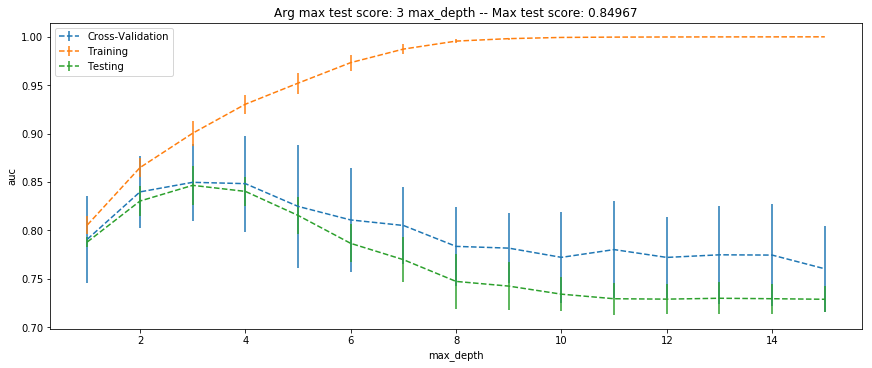

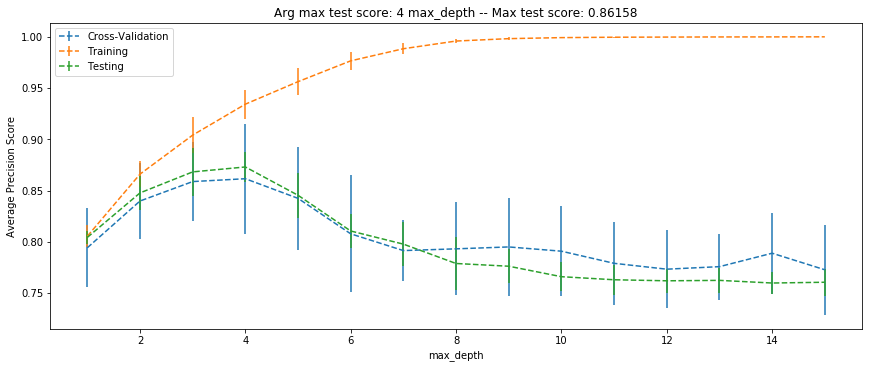

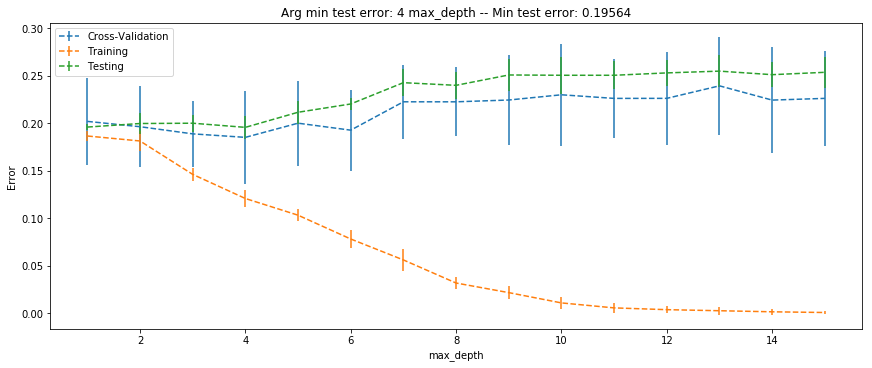

In [7]:
kfold_n_splits = 6
max_size = 16
size_keys =  ["max_depth"]
score_keys = ["ROC", "PrecisionRecall", "Error"]
dec_tree_test_score = {key: 0 for key in score_keys}
for score in score_keys:
    dec_tree_test_score[score] = plot_cross_validate(DecisionTreeClassifier, X_train_juice, X_test_juice, y_train_juice,
                                     y_test_juice, kfold_n_splits, max_size, size_keys, score = score)

### Random Forest Tree Classifier - Cross Validation

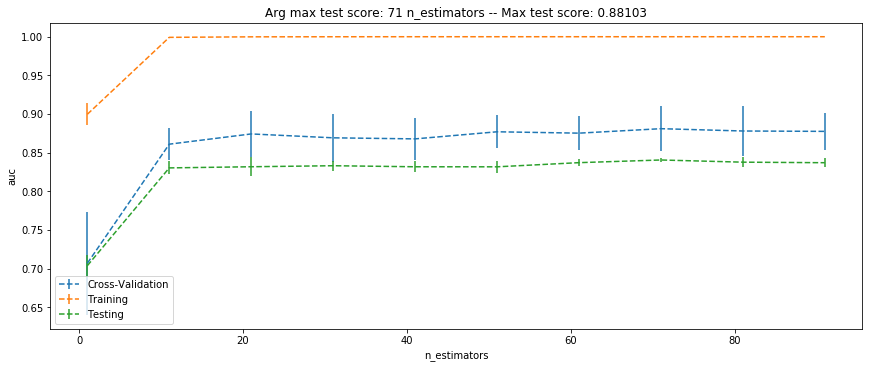

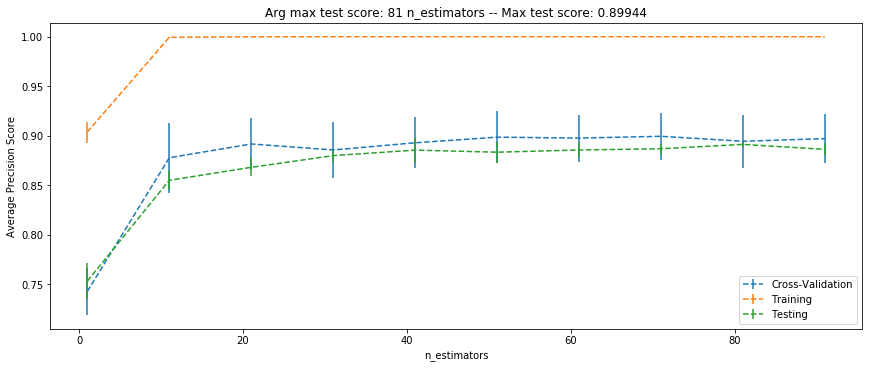

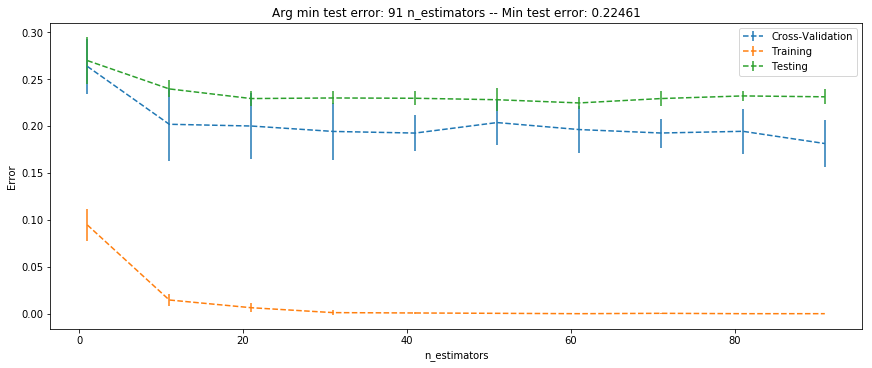

In [8]:
kfold_n_splits = 6
max_size = 100
size_keys =  ["n_estimators"]
score_keys = ["ROC", "PrecisionRecall", "Error"]
rforest_test_score = {key: 0 for key in score_keys}
for score in score_keys:
    rforest_test_score[score] = plot_cross_validate(RandomForestClassifier, X_train_juice, X_test_juice, y_train_juice,
                                 y_test_juice, kfold_n_splits, max_size, size_keys, score = score, step = 10)

### LDA - Cross Validation

In [9]:
kfold_n_splits = 6
score_keys = ["ROC", "PrecisionRecall", "Error"]
lda_test_score = {key: 0 for key in score_keys}
for score in score_keys:
    lda_test_score[score] = cross_validate_scores(LDA, X_train_juice, X_test_juice, y_train_juice,
                                 y_test_juice, kfold_n_splits, max_size, size_keys, score = score)["test_score"]

### Log Regression - Cross Validation

In [10]:
kfold_n_splits = 6
score_keys = ["ROC", "PrecisionRecall", "Error"]
log_test_score = {key: 0 for key in score_keys}
for score in score_keys:
    log_test_score[score] = cross_validate_scores(LogRegression, X_train_juice, X_test_juice, y_train_juice,
                                 y_test_juice, kfold_n_splits, max_size, size_keys, score = score)["test_score"]

### Print Score Dictionaries

In [11]:
print("Decision Tree", dec_tree_test_score)
print("Random Forest", rforest_test_score)
print("LDA", lda_test_score)
print("Log Regression", log_test_score)

Decision Tree {'ROC': 0.7288402263649788, 'PrecisionRecall': 0.7598349725904373, 'Error': 0.19563862928348907}
Random Forest {'ROC': 0.7037929018127039, 'PrecisionRecall': 0.7531097025212237, 'Error': 0.22461059190031155}
LDA {'ROC': 0.8959078880861057, 'PrecisionRecall': 0.9352637504280414, 'Error': 0.1736822429906542}
Log Regression {'ROC': 0.8917692444920168, 'PrecisionRecall': 0.9322888329159575, 'Error': 0.17345794392523356}


En Decision Tree y Random Forest, se imprimen los valores de los mejores de los scores y el error para el mejor clasificador. Esto es para el Decision Tree con el mejor max_depth y el Random Forest con el mejor número de estimadores (con $m = \sqrt{p}$)

Observando las tres medidas de desempeño *Area under the ROC curve*, *Average Precision* y *Classification error* en el set de test para K-fold cross validation con *K=6* los mejores clasificadores son **LDA** y **Log Regression**. En terminos de  las medidas de desempeño listadas estos dos varian por muy poco